# Inversion with a corrected shapefile for Nordic Glacier

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray as xr

import oggm
import os
from oggm import cfg, utils, workflow, tasks, graphics
from oggm.core import inversion
cfg.initialize(logging_level='WORKFLOW')
products_dir = '/home/pelto/Desktop/ice_thick/'
fl_smooth = 0.1

2019-11-17 12:15:23: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


Let's read a file from the standard RGI:

In [2]:
utils.get_rgi_dir(version='61')

'/home/pelto/OGGM/rgi/RGIV61'

In [3]:
sh = utils.get_rgi_region_file('02', version='61')
sh

'/home/pelto/OGGM/rgi/RGIV61/02_rgi61_WesternCanadaUS/02_rgi61_WesternCanadaUS.shp'

Shapefiles are best read an manipulated with [geopandas](http://geopandas.org/) in python (see also oggm [working_with_rgi.ipynb](working_with_rgi.ipynb) tutorial):

In [4]:
gdf = gpd.read_file(sh)
gdf.head()

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,check_geom,geometry
0,RGI60-02.00001,G238765E49002N,20049999,20069999,-121.235,49.0019,2,4,0.073,1938,...,304,0,0,0,0,0,9,None,None,"POLYGON ((-121.237179 49.00120000000004, -121...."
1,RGI60-02.00002,G238410E49162N,20049999,20069999,-121.590,49.1617,2,4,0.262,1726,...,817,0,0,0,0,0,9,None,WARN:WasInvalid;,"POLYGON ((-121.5911818 49.15867800100006, -121..."
2,RGI60-02.00003,G238791E49163N,20049999,20069999,-121.209,49.1627,2,4,0.307,2002,...,478,0,0,0,0,0,9,None,None,"POLYGON ((-121.207506 49.16608200000007, -121...."
3,RGI60-02.00004,G238399E49166N,20049999,20069999,-121.601,49.1657,2,4,0.184,1563,...,376,0,0,0,0,0,9,None,None,POLYGON ((-121.5965409999999 49.16728500000005...
4,RGI60-02.00005,G238389E49167N,20049999,20069999,-121.611,49.1666,2,4,0.274,1668,...,676,0,0,0,0,0,9,None,None,POLYGON ((-121.6079999999999 49.16802400000006...


## Get the RGI geometry and plot it

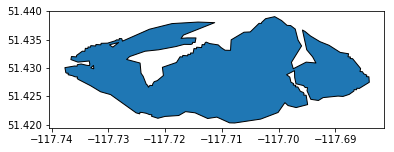

In [5]:
# OGGM set-up
cfg.PATHS['working_dir'] = utils.gettempdir(dirname='nordic_intersects', reset=True)
cfg.PARAMS['border'] = 10
cfg.PARAMS['flowline_height_smooth'] = fl_smooth

# Get the geometry and plot it
gl = utils.get_rgi_glacier_entities(['RGI60-02.04264'], version='61') ##unless I put the version here it doesn't call V61
gl.plot(edgecolor='k');

Nordic Glacier should not be assigned the western wing, and the eastern wing actually flows into the central portion of the glacier, the gap is due to a medial moraine.

### Make a new "RGI file"

There is no simple way to automate the process of finding bad geometries, but the OGGM community is [working on this](https://github.com/OGGM/partitioning) Here we use a geometry that we prepared in QGIS from Pelto et al. (2019) https://www.the-cryosphere.net/13/1709/2019/

In [6]:
# We simulate the case where we only have the geometry, nothing else
divides = gpd.read_file('/home/pelto/oggm_runs/OGGM-Columbia-Project/outlines/nordic_divided_2014.shp') 
divides = divides.loc[divides.RGIId == 'RGI60-02.04264'][['geometry']]
divides

,geometry
0,POLYGON ((-117.7251266266143 51.42201803589593...
1,POLYGON ((-117.7210915267804 51.43772012281782...


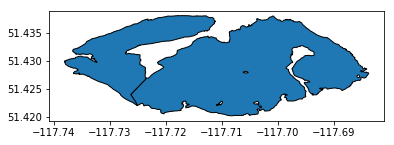

In [7]:
divides.plot(edgecolor='k');

Now we use the RGI entity as template - it's good to use the same attributes as the original RGI glacier, because most of them are already correct:

In [8]:
template = pd.concat([gl]*2, ignore_index=True)
template

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,check_geom,geometry
0,RGI60-02.04264,G242290E51429N,20049999,20069999,-117.71,51.4292,2,3,4.425,1979,...,2540,0,0,0,0,0,9,None,None,"POLYGON ((-117.699563 51.43844000000007, -117...."
1,RGI60-02.04264,G242290E51429N,20049999,20069999,-117.71,51.4292,2,3,4.425,1979,...,2540,0,0,0,0,0,9,None,None,"POLYGON ((-117.699563 51.43844000000007, -117...."


We change the important ones:

In [9]:
# Attributes
template['RGIId'] = ['RGI60-02.04264', 'RGI60-02.04264_d02']
template['Name'] = ['Nordic', 'Escargot']
# Geometries
template['geometry'] = divides['geometry'].values
# Center point
for i, geom in template[['geometry']].iterrows():
    cenlon, cenlat = geom.geometry.centroid.xy
    template.loc[i, 'CenLon'] = cenlon
    template.loc[i, 'CenLat'] = cenlat
# This is important to properly georeference the file
import salem
template.crs = salem.wgs84.srs

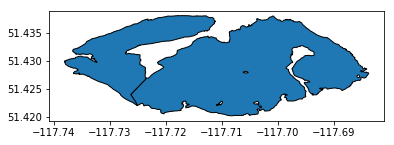

In [10]:
template.plot(edgecolor='k');

Save it: 

In [11]:
nord_new_shape_path = os.path.join(cfg.PATHS['working_dir'], 'nordic_divided.shp')
template.to_file(nord_new_shape_path)

/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


### Compute the interects

In [12]:
intersects_wna = gpd.read_file(utils.get_rgi_intersects_region_file('02'))
intersects_nord = intersects_wna.loc[(intersects_wna.RGIId_1 == 'RGI60-02.04264') | (intersects_wna.RGIId_2 == 'RGI60-02.04264')]
intersects_nord

,RGIId_1,RGIId_2,geometry


Ok, we can now create a file which has all the glaciers we need to compute the relevant intersects (note that we could also use the full standard RGI with just Nordic and Escargot replaced):

Good! Let's use [rgitools](https://rgitools.readthedocs.io) to compute the intersects for this new situation: 

In [13]:
from rgitools.funcs import compute_intersects
new_intersects = compute_intersects(template)  #for_intersects  ##removed as no adjacent glacier at Nordic

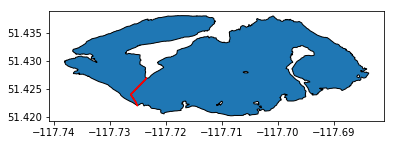

In [14]:
f, ax = plt.subplots()
template.plot(ax=ax, edgecolor='k');  #for_intersects
new_intersects.plot(ax=ax, edgecolor='r');  

Good! We can store our intersects to use them with OGGM afterwards:

In [15]:
nord_intersects_path = os.path.join(cfg.PATHS['working_dir'], 'nordic_divided_intersects.shp')
new_intersects.to_file(nord_intersects_path)

### Finally: the OGGM run 

In [16]:
# This is important! We tell OGGM to recompute the glacier area for us
cfg.PARAMS['use_rgi_area'] = False
# This is the default anyway, but we set it here to be sure
cfg.PARAMS['use_intersects'] = True
cfg.PARAMS['flowline_height_smooth'] = fl_smooth
# This is important!
cfg.set_intersects_db(nord_intersects_path)
nord_intersects_path

'/tmp/OGGM/nordic_intersects/nordic_divided_intersects.shp'

In [17]:
# This is important again - standard OGGM 
rgidf = gpd.read_file(nord_new_shape_path)
rgidf

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,check_geom,geometry
0,RGI60-02.04264,G242290E51429N,20049999,20069999,-117.705247,51.428228,2,3,4.425,1979,...,2540,0,0,0,0,0,9,Nordic,None,POLYGON ((-117.7251266266143 51.42201803589593...
1,RGI60-02.04264_d02,G242290E51429N,20049999,20069999,-117.726086,51.431812,2,3,4.425,1979,...,2540,0,0,0,0,0,9,Escargot,None,POLYGON ((-117.7210915267804 51.43772012281782...


In [18]:
gdirs = workflow.init_glacier_regions(rgidf, reset=True, force=True)

Execute entity task define_glacier_region on 2 glaciers
Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


In [19]:
workflow.execute_entity_task(tasks.glacier_masks, gdirs);
workflow.execute_entity_task(tasks.compute_centerlines, gdirs);
workflow.execute_entity_task(tasks.initialize_flowlines, gdirs);
workflow.execute_entity_task(tasks.catchment_area, gdirs);
workflow.execute_entity_task(tasks.catchment_width_geom, gdirs);
workflow.execute_entity_task(tasks.catchment_width_correction, gdirs);

Execute entity task glacier_masks on 2 glaciers
Execute entity task compute_centerlines on 2 glaciers
Execute entity task initialize_flowlines on 2 glaciers
Execute entity task catchment_area on 2 glaciers
Execute entity task catchment_width_geom on 2 glaciers
Execute entity task catchment_width_correction on 2 glaciers


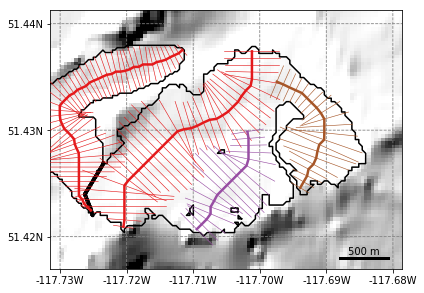

In [20]:
# ll = -117.75, 51.415, -117.68, 51.44 ## tried to specify ll ur coordinates to force plot...but supposed to be dict
f, ax = plt.subplots(1, 1, figsize=(6, 6))
graphics.plot_catchment_width(gdirs, add_intersects=True, corrected=True, ax=ax) # ax=ax lonlat_contours_kwargs=ll)
# graphics.plot_domain(gdirs)
plt.tight_layout()

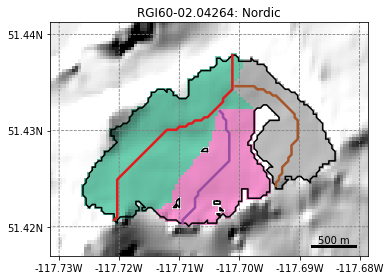

In [21]:
graphics.plot_catchment_areas(gdirs[0]);

In [22]:
##inversion time
workflow.gis_prepro_tasks(gdirs)
workflow.climate_tasks(gdirs)
workflow.inversion_tasks(gdirs)
workflow.execute_entity_task(tasks.distribute_thickness_per_altitude, gdirs);

Execute entity task glacier_masks on 2 glaciers
Execute entity task compute_centerlines on 2 glaciers
Execute entity task initialize_flowlines on 2 glaciers
Execute entity task compute_downstream_line on 2 glaciers
Execute entity task compute_downstream_bedshape on 2 glaciers
Execute entity task catchment_area on 2 glaciers
Execute entity task catchment_intersections on 2 glaciers
Execute entity task catchment_width_geom on 2 glaciers
Execute entity task catchment_width_correction on 2 glaciers
Execute entity task process_cru_data on 2 glaciers
Execute entity task local_t_star on 2 glaciers
Execute entity task mu_star_calibration on 2 glaciers
Execute entity task prepare_for_inversion on 2 glaciers
Execute entity task mass_conservation_inversion on 2 glaciers
Execute entity task filter_inversion_output on 2 glaciers
Execute entity task distribute_thickness_per_altitude on 2 glaciers


In [23]:
gdir = gdirs[0]
tasks.init_present_time_glacier(gdir)

In [24]:
ds_divided = xr.open_dataset(gdir.get_filepath('gridded_data')).load()
ds_divided.close() 

This is the mean ice thickness:

In [25]:
print(ds_divided.distributed_thickness.mean())
thickness_divided = ds_divided.distributed_thickness

<xarray.DataArray 'distributed_thickness' ()>
array(53.521297, dtype=float32)


The next two boxes are the model flowline thickness:

In [26]:
mfl=gdir.read_pickle('model_flowlines')
thickness_divided = mfl[-1].surface_h - mfl[-1].bed_h
thickness_divided.mean()

57.43581805748733

In [27]:
default_divided_thick = thickness_divided[thickness_divided>0].mean()
print('default_divided_thickness:', default_divided_thick)

default_divided_thickness: 65.41301500991614


## SMB gradient

In [28]:
num = 5 #num determines which gdir and gradient to use, refer to list below to select desired site

# min to max gradients
# grad = [5.8, 9.8, 5.9, 7.95, 6.2, 5.3, 5.8] #mm we m-1
#data points gradients
grad = [6.84, 9.8, 7.11, 7.95, 10.84, 6.01, 7.92] # mm w.e. m-1 

srtm = [-1.58, -6.95, -6.47, -5.71, -5.86, -6.11, 0.48]

# products_dir = '/home/pelto/Desktop/ice_thick/'
glacier = ['Kokanee', 'Haig', 'Conrad', 'W.Washmawapta', 'Illecillewaet', 'Nordic', 'Zillmer']
# gdirs

# Print the standard MB gradient from OGGM default
from oggm.core.massbalance import ConstantMassBalance, MultipleFlowlineMassBalance
# gdir = gdirs[num]

mb_mod = MultipleFlowlineMassBalance(gdir, use_inversion_flowlines=False, mb_model_class=ConstantMassBalance)
z, w, mb_on_z = mb_mod.get_annual_mb_on_flowlines()
mb_on_z *=  cfg.PARAMS['ice_density'] * cfg.SEC_IN_YEAR

In [29]:
# grad_line = np.polyfit(mb_on_z,z,2)
from scipy import stats 
slope, intercept, r_value, p_value, std_err = stats.linregress(z, mb_on_z)
print("slope: %f    intercept: %f" % (slope, intercept), "  R-squared: %f" % r_value**2)

slope: 5.459327    intercept: -14004.269420   R-squared: 0.911125


In [30]:
# Let's apply a linear MB instead
from oggm.core.climate import apparent_mb_from_linear_mb

# This is important! We tell OGGM to recompute the glacier area for us
cfg.PARAMS['use_rgi_area'] = False
# This is the default anyway, but we set it here to be sure
cfg.PARAMS['use_intersects'] = True
# This is important!
cfg.set_intersects_db(nord_intersects_path)
print(nord_intersects_path)
###not sure I need to re-iterate the above lines...added in just in case

workflow.execute_entity_task(tasks.apparent_mb_from_linear_mb, gdir, mb_gradient=grad[num]);

# Compare what we got from this
from oggm.core.massbalance import LinearMassBalance

Execute entity task apparent_mb_from_linear_mb on 1 glaciers


/tmp/OGGM/nordic_intersects/nordic_divided_intersects.shp


Multiprocessing: using all available processors (N=8)


In [31]:
params = gdir.read_pickle('linear_mb_params')
print(params)

{'ela_h': 2508.9898695360416, 'grad': 6.01}


In [32]:
l_mb_mod = LinearMassBalance(params['ela_h'], grad=params['grad'])
l_mb_on_z = l_mb_mod.get_annual_mb(z) * cfg.PARAMS['ice_density'] * cfg.SEC_IN_YEAR

slope default: 5.459327    intercept: -14004.269420   R-squared: 0.911125
slope: 6.010000    intercept: -15079.029116   R-squared: 1.000000


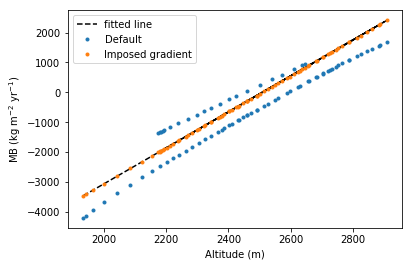

In [33]:
slope, intercept, r_value, p_value, std_err = stats.linregress(z, mb_on_z)
print("slope default: %f    intercept: %f" % (slope, intercept), "  R-squared: %f" % r_value**2)
slope, intercept, r_value, p_value, std_err = stats.linregress(z, l_mb_on_z)
print("slope: %f    intercept: %f" % (slope, intercept), "  R-squared: %f" % r_value**2)

plt.plot(z, intercept + slope*z, 'k--', label='fitted line');
plt.plot(z, mb_on_z, '.', label='Default');
plt.plot(z, l_mb_on_z, '.', label='Imposed gradient');
plt.ylabel('MB (kg m$^{-2}$ yr$^{-1}$)');
plt.xlabel('Altitude (m)');
plt.legend();

In [34]:
# Now let's recompute the inversion based on this new gradient
cfg.PARAMS['flowline_height_smooth'] = fl_smooth
workflow.inversion_tasks(gdirs)
workflow.execute_entity_task(tasks.distribute_thickness_per_altitude, gdirs);
tasks.init_present_time_glacier(gdir) ##trying to update the model flowline

#ds_new is the linear SMB inversion dataset
ds_new = xr.open_dataset(gdir.get_filepath('gridded_data')).load()
ds_new.close() 

Execute entity task prepare_for_inversion on 2 glaciers
Multiprocessing: using all available processors (N=8)
Execute entity task mass_conservation_inversion on 2 glaciers
Execute entity task filter_inversion_output on 2 glaciers
Execute entity task distribute_thickness_per_altitude on 2 glaciers


In [35]:
ds_divided['distributed_thickness']

<xarray.DataArray 'distributed_thickness' (y: 75, x: 102)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * x        (x) float32 -1804.9161 -1768.9161 ... 1795.0839 1831.0839
  * y        (y) float32 5698878.5 5698842.5 5698806.5 ... 5696250.5 5696214.5
Attributes:
    units:      -
    long_name:  Distributed ice thickness

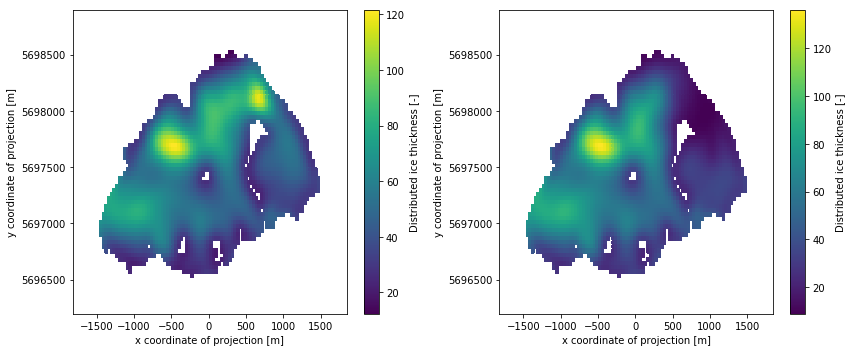

In [36]:
##side by side thickness...fine but hard to compare
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5));
ds_divided.distributed_thickness.plot(ax=ax1); #default cmap is viridis
ds_new.distributed_thickness.plot(ax=ax2);
plt.tight_layout();

whole glacier thicknesses:

In [37]:
print(np.mean(ds_new.distributed_thickness))
print(ds_divided.distributed_thickness.mean())

<xarray.DataArray 'distributed_thickness' ()>
array(50.26057, dtype=float32)
<xarray.DataArray 'distributed_thickness' ()>
array(53.521297, dtype=float32)


In [38]:
mfl=gdir.read_pickle('model_flowlines')
thickness_MB = mfl[-1].surface_h - mfl[-1].bed_h
thickness_MB.mean()

60.70907618376474

Model flowline thickness:

In [39]:
MB_thick = thickness_MB[thickness_MB>0].mean()
print(np.round(MB_thick , 2))

69.14


In [40]:
diff =  MB_thick - default_divided_thick
print(np.round(diff, 2))

3.73


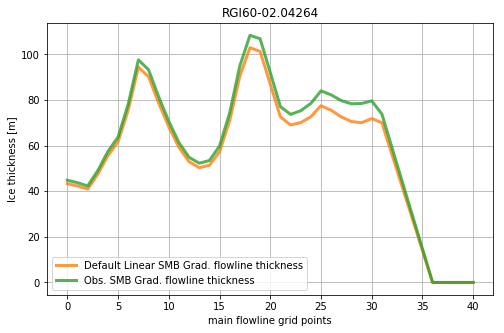

In [41]:
fig, ax = plt.subplots(figsize=[8,5])
ax.plot(thickness_divided, 'C1', label='Default Linear SMB Grad. flowline thickness', linewidth=3, alpha=0.8)
ax.plot(thickness_MB, 'C2', label='Obs. SMB Grad. flowline thickness', linewidth=3, alpha=0.8)
ax.set_xlabel('main flowline grid points')
ax.set_ylabel('Ice thickness [m]')
ax.set_title(gdir.rgi_id)
ax.grid(True)
ax.legend();
# fig.savefig(products_dir + glacier[num] +'.tiff')

In [42]:
utils.compile_glacier_statistics(gdirs, inversion_only=False)

Execute entity task glacier_statistics on 2 glaciers


,rgi_region,rgi_subregion,name,cenlon,cenlat,rgi_area_km2,glacier_type,terminus_type,status,inv_volume_km3,...,flowline_mean_elev,flowline_max_elev,flowline_min_elev,flowline_avg_width,flowline_avg_slope,t_star,mu_star_glacierwide,mu_star_flowline_avg,mu_star_allsame,mb_bias
rgi_id,,,,,,,,,,,,,,,,,,,,,
RGI60-02.04264,02,02-03,Nordic,-117.705247,51.428228,3.404,Glacier,Land-terminating,Glacier or ice cap,0.179650,...,2508.989870,2910.295861,2084.667814,1260.740741,0.329866,1935,154.955754,156.065201,False,320.446356
RGI60-02.04264_d02,02,02-03,Escargot,-117.726086,51.431812,1.210,Glacier,Land-terminating,Glacier or ice cap,0.068897,...,2447.284129,2839.582275,2111.311548,896.296296,0.264520,1934,141.301350,141.301350,True,320.600388


## Default RGI Nordic

In [43]:
WORKING_DIR = utils.gettempdir('nordic_default')
utils.mkdir(WORKING_DIR, reset=True)
cfg.initialize(logging_level='WORKFLOW')
cfg.PATHS['working_dir'] = WORKING_DIR

2019-11-17 12:15:32: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


In [44]:
cfg.PARAMS['border'] = 10
cfg.PARAMS['use_intersects'] = False
cfg.PARAMS['flowline_height_smooth'] = fl_smooth

In [45]:
rgidf2 = utils.get_rgi_glacier_entities(['RGI60-02.04264'], version='60')
gdirs2 = workflow.init_glacier_regions(rgidf2)
workflow.gis_prepro_tasks(gdirs2)
workflow.climate_tasks(gdirs2)
workflow.inversion_tasks(gdirs2)
workflow.execute_entity_task(tasks.distribute_thickness_per_altitude, gdirs2);

gdir2 = gdirs2[0]
tasks.init_present_time_glacier(gdir2) ##This updates the mode_flowlines file and creates a stand-alone numerical glacier ready to run.

2019-11-17 12:15:34: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers
2019-11-17 12:15:34: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-11-17 12:15:34: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-11-17 12:15:34: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-11-17 12:15:34: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-11-17 12:15:34: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-11-17 12:15:34: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-11-17 12:15:34: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-11-17 12:15:35: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anacon

In [46]:
dem_path = gdir2.get_filepath('dem')
dem_path

'/tmp/OGGM/nordic_default/per_glacier/RGI60-02/RGI60-02.04/RGI60-02.04264/dem.tif'

In [47]:
ds_default = xr.open_dataset(gdir2.get_filepath('gridded_data')).load()
ds_default.close() 

In [48]:
print(ds_default.distributed_thickness.mean())
thickness_default = ds_default.distributed_thickness

<xarray.DataArray 'distributed_thickness' ()>
array(50.60127, dtype=float32)


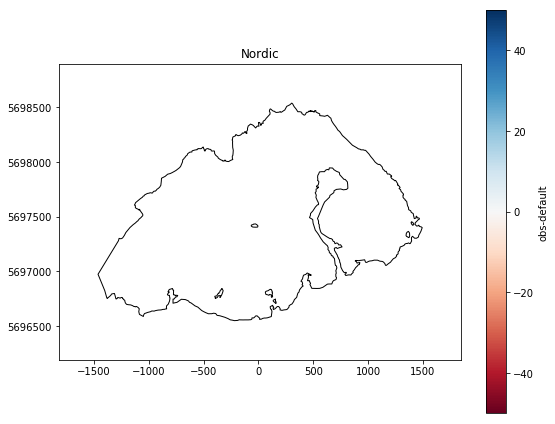

In [49]:
f, ax = plt.subplots(figsize=(8,6))
ds_new['obs-default'] = (ds_new.distributed_thickness - ds_default.distributed_thickness)
ds_new['obs-default'].plot(ax=ax, cmap='RdBu', vmin =-50, vmax=50); #'RdBu'
plt.ylabel('')
plt.xlabel('')
plt.title(glacier[num])
gdir.read_shapefile('outlines').plot(ax=ax, color='none', edgecolor='black');
plt.tight_layout()
# plt.savefig('/home/pelto/Desktop/ice_thick/' + glacier[num] + '_mb_grad_diff.png', dpi=600)

In [50]:
mfl=gdir.read_pickle('model_flowlines')
thickness_default = mfl[-1].surface_h - mfl[-1].bed_h
thickness_default.mean()

60.70907618376474

In [51]:
thickness_default[thickness_default>0].mean()

69.14089232039873

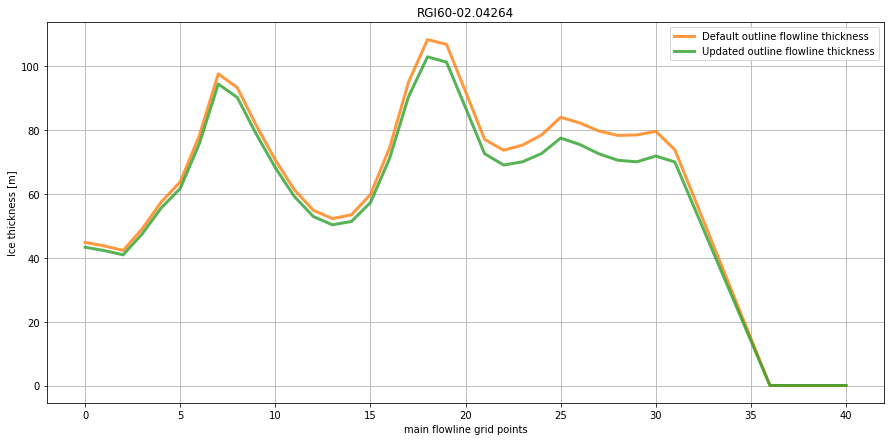

In [52]:
fig, ax = plt.subplots(figsize=[15,7])
ax.plot(thickness_default, 'C1', label='Default outline flowline thickness', linewidth=3, alpha=0.8)
ax.plot(thickness_divided, 'C2', label='Updated outline flowline thickness', linewidth=3, alpha=0.8)
ax.set_xlabel('main flowline grid points')
ax.set_ylabel('Ice thickness [m]')
ax.set_title(gdir.rgi_id)
ax.grid(True)
ax.legend();
# fig.savefig('/home/pelto/kokanee.png')

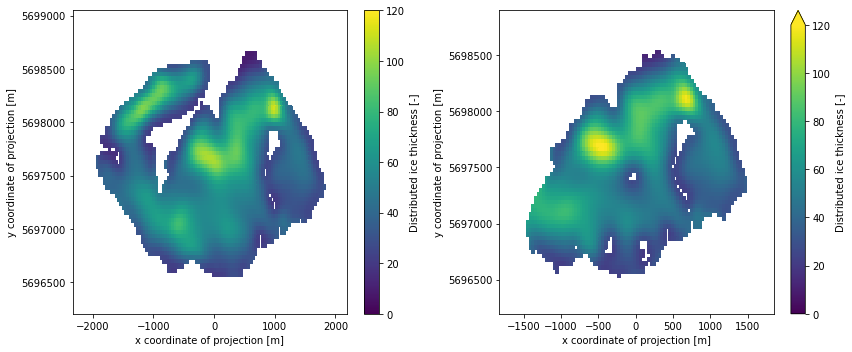

In [53]:
##side by side thickness...fine but hard to compare
vmax=120
vmin=0
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5));
ds_default.distributed_thickness.plot(ax=ax1, vmin=vmin, vmax=vmax); #default cmap is viridis
ds_divided.distributed_thickness.plot(ax=ax2, vmin=vmin, vmax=vmax);
plt.tight_layout();
plt.savefig(products_dir + '_nordic_side_by_side_outline_corr_thick.png', dpi=300)

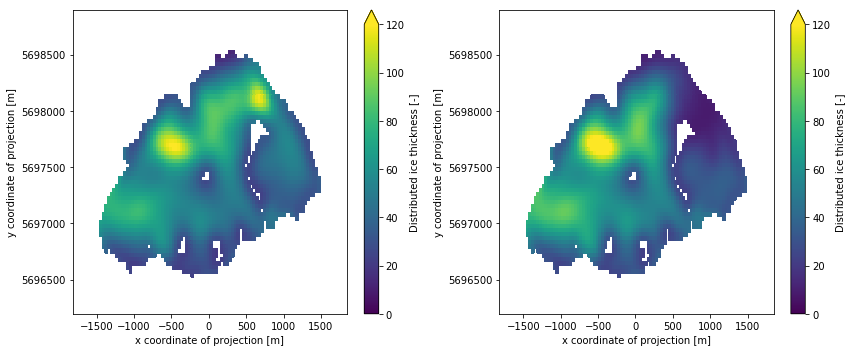

In [54]:
##side by side thickness...fine but hard to compare
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5));
ds_divided.distributed_thickness.plot(ax=ax1, vmin=vmin, vmax=vmax); #default cmap is viridis
ds_new.distributed_thickness.plot(ax=ax2, vmin=vmin, vmax=vmax);
plt.tight_layout();
# plt.savefig(products_dir + '_nordic_side_by_side_outline_corr_thick.png', dpi=300)

/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/salem/datasets.py:171: RuntimeWarning: x0 out of bounds
  warnings.warn('x0 out of bounds', RuntimeWarning)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/salem/datasets.py:173: RuntimeWarning: y0 out of bounds
  warnings.warn('y0 out of bounds', RuntimeWarning)


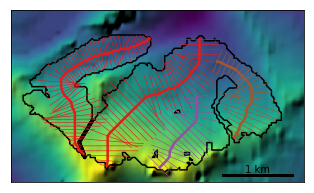

In [55]:
# We prepare for the plot, which needs our own map to proceed.
# Lets do a local mercator grid
g = salem.mercator_grid(center_ll=(-117.71, 51.43),
                        extent=(4250, 2500))
# And a map accordingly
sm = salem.Map(g, countries=False)
sm.set_lonlat_contours(interval=0)
z = sm.set_topography(dem_path)#os.path.join(cfg.PATHS['tmp_dir'], 'ISL.tif'))
sm.set_data(z)


# Figs
f = 0.75
f, ax = plt.subplots(1, 1, figsize=(7 * f, 10 * f))

graphics.plot_catchment_width(gdirs, add_intersects=True, corrected=True, ax=ax, smap=sm)

## GPR Data import and comparison

In [56]:
shapefile = ['2017/Kokanee_17_final_WGS84.shp', 'Haig/Haig_gpr_all_WGS84.shp', 'conrad_GPR_ALL_final_WGS84.shp', 
             'west_wash_data.shp', '2018/illec_may18_final_WGS84_clipped.shp', '2016/Nordic_2016_GPR_final_WGS84.shp', 
             'zillmer_GPR_All_final_WGS84.shp']

df = salem.read_shapefile('/home/pelto/GIS/GPR/Data/' + shapefile[num])

coords = np.array([p.xy for p in df.geometry]).squeeze()
df['lon'] = coords[:, 0]
df['lat'] = coords[:, 1]
# df['lon'] = df[4]
# df['lat'] = df[5]
df = df[['lon', 'lat', 'depth']]

# Convert the longitudes and latitudes to the glacier map projection:
xx, yy = salem.transform_proj(salem.wgs84, gdir.grid.proj, df['lon'].values, df['lat'].values)
df['x'] = xx
df['y'] = yy

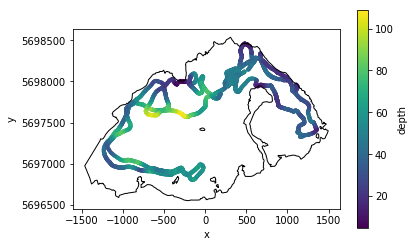

In [57]:
#plot these data
geom = gdir.read_shapefile('outlines')
f, ax = plt.subplots()
df.plot.scatter(x='x', y='y', c='depth',cmap='viridis', s=10, ax=ax); #cmap='Blues',
geom.plot(ax=ax, facecolor='none', edgecolor='k');

 The measurement points of this dataset are very frequent and close to each other. There are plenty of them:

In [58]:
len(df)

3178

### Aggregated per grid point

In [59]:
df_agg = df[['lon', 'lat', 'depth']].copy()
ii, jj = gdir.grid.transform(df['lon'], df['lat'], crs=salem.wgs84, nearest=True)
df_agg['i'] = ii
df_agg['j'] = jj
# We trick by creating an index of similar i's and j's
df_agg['ij'] = ['{:04d}_{:04d}'.format(i, j) for i, j in zip(ii, jj)]
df_agg = df_agg.groupby('ij').mean()

df_agg2 = df[['lon', 'lat', 'depth']].copy()
ii, jj = gdir.grid.transform(df['lon'], df['lat'], crs=salem.wgs84, nearest=True)
df_agg2['i'] = ii
df_agg2['j'] = jj
# We trick by creating an index of similar i's and j's
df_agg2['ij'] = ['{:04d}_{:04d}'.format(i, j) for i, j in zip(ii, jj)]
df_agg2 = df_agg2.groupby('ij').mean()

In [60]:
# Here, we will keep them all and interpolate the variables of interest at a the point's location. 
# We use xarray for this:
vns = ['topo',
       'slope',
       'slope_factor',
       'aspect',
       'dis_from_border',
#        'catchment_area',
#        'lin_mb_above_z',
#        'lin_mb_above_z_on_catch',
#        'oggm_mb_above_z',
#        'oggm_mb_above_z_on_catch',
       ]

In [61]:
len(df_agg)

453

In [62]:
# Select
for vn in vns:
    df_agg[vn] = ds_divided[vn].isel(x=('z', df_agg.i), y=('z', df_agg.j))
    df_agg2[vn] = ds_default[vn].isel(x=('z', df_agg2.i), y=('z', df_agg2.j))

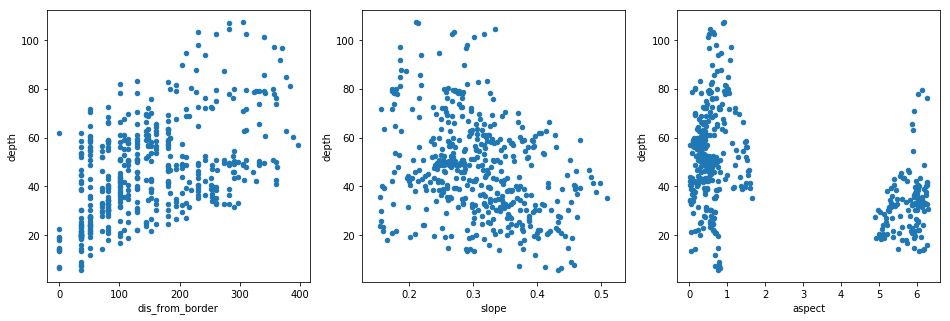

In [63]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
df_agg.plot.scatter(x='dis_from_border', y='depth', ax=ax1);
df_agg.plot.scatter(x='slope', y='depth', ax=ax2);
df_agg.plot.scatter(x='aspect', y='depth', ax=ax3);

In [64]:
# Add the linear model data for comparison
# ds = xr.open_dataset(gdir.get_filepath('gridded_data'))
df_agg['oggm_thick'] = ds_divided.distributed_thickness.isel(x=('z', df_agg['i']), y=('z', df_agg['j']))
df_agg['obs_mb_grad_thick'] = ds_new.distributed_thickness.isel(x=('z', df_agg['i']), y=('z', df_agg['j']))
df_agg2['default_thick'] = ds_default.distributed_thickness.isel(x=('z', df_agg2['i']), y=('z', df_agg2['j']))

In [65]:
print(len(df_agg['depth']), len(df_agg['oggm_thick']))
print('oggm_thick divided:', np.round(np.mean(df_agg['oggm_thick']) + srtm[num],2), np.round(np.std(df_agg['oggm_thick']) + srtm[num],2))
print('obs_mb_grad_thick:', np.round(np.mean(df_agg['obs_mb_grad_thick'])+ srtm[num],2), np.round(np.std(df_agg['obs_mb_grad_thick']) + srtm[num],2))
print('default rgi thick:', np.round(np.mean(df_agg2['default_thick']) + srtm[num],2), np.round(np.std(df_agg2['default_thick']) + srtm[num],2))

453 453
oggm_thick divided: 58.45 13.68
obs_mb_grad_thick: 48.49 23.59
default rgi thick: 40.42 11.07


In [66]:
print('GPR depth (m):', np.round(np.mean(df_agg['depth']),2), np.round(np.std(df_agg['depth']),2))

GPR depth (m): 47.14 19.8


In [67]:
print('mean observed depth point:', df['depth'].mean())
print('max observed depth gridded:', df_agg['depth'].max())
print('max observed depth point:', df['depth'].max())

mean observed depth point: 47.64562303335399
max observed depth gridded: 107.157
max observed depth point: 108.77


In [68]:
df_diff = df_agg['depth'] - (df_agg['oggm_thick']) #- 1.0)
#df_diff
print('mean diff:', np.mean(df_diff))
print('med. diff:', np.nanmedian(df_diff))

mean diff: -17.41932158777455
med. diff: -17.96525508335658


Text(0.5, 1.0, 'GPR depth less oggm default thickness')

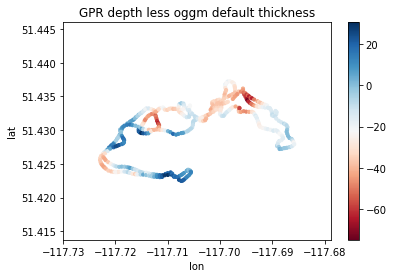

In [69]:
#GPR depth less oggm default thickness
# geom = gdir.read_shapefile('outlines')
f, ax = plt.subplots()
diff = df_agg['depth'] - df_agg['oggm_thick']
df_agg.plot.scatter(x='lon', y='lat', c=diff, cmap='RdBu', s=10, ax=ax); #cmap='Blues',
# geom.plot(ax=ax, facecolor='no
plt.title('GPR depth less oggm default thickness')

Text(0.5, 1.0, 'GPR depth less OGGM SMB thickness')

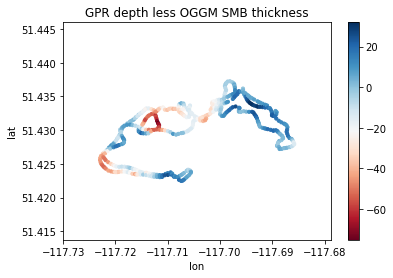

In [70]:
#GPR depth less OGGM SMB thickness
# geom = gdir.read_shapefile('outlines')
f, ax = plt.subplots()
diff2 = df_agg['depth'] - df_agg['obs_mb_grad_thick']
df_agg.plot.scatter(x='lon', y='lat', c=diff2, cmap='RdBu', s=10, ax=ax); #cmap='Blues',
plt.title('GPR depth less OGGM SMB thickness')
# geom.plot(ax=ax, facecolor='no

Text(0.5, 1.0, 'GPR depth less RGI default thickness')

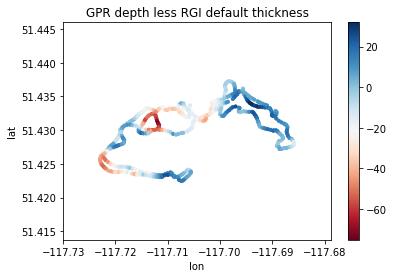

In [71]:
#GPR depth less RGI default thickness
# geom = gdir.read_shapefile('outlines')
f, ax = plt.subplots()
diff3 = df_agg2['depth'] - df_agg2['default_thick']
df_agg2.plot.scatter(x='lon', y='lat', c=diff2, cmap='RdBu', s=10, ax=ax); #cmap='Blues',
# geom.plot(ax=ax, facecolor='no
plt.title('GPR depth less RGI default thickness')

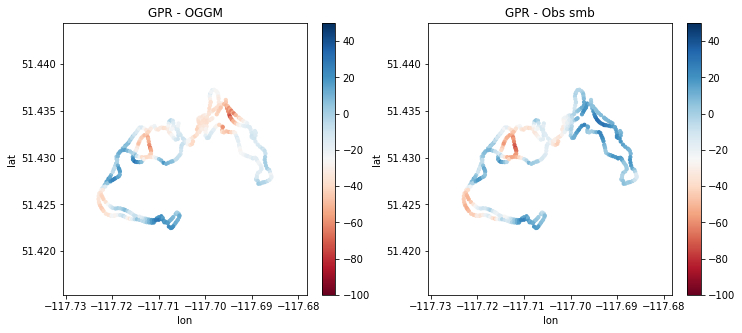

In [72]:
#GPR depth less oggm default thickness
# geom = gdir.read_shapefile('outlines')
f, (ax,ax1) = plt.subplots(1,2, figsize=(12, 5))
df_agg['GPR-oggm'] = df_agg['depth'] - df_agg['oggm_thick']
df_agg.plot.scatter(x='lon', y='lat', c=df_agg['GPR-oggm'], cmap='RdBu', s=10, ax=ax, vmax=50, vmin=-100); #cmap='Blues',
ax.title.set_text('GPR - OGGM')
# geom.plot(ax=ax, facecolor='no
#GPR depth less OGGM SMB thickness


geom = gdir.read_shapefile('outlines')
df_agg['GPR-obs_smb'] = df_agg['depth'] - df_agg['obs_mb_grad_thick']
df_agg.plot.scatter(x='lon', y='lat', c=df_agg['GPR-obs_smb'], cmap='RdBu', s=10, vmax=50, vmin=-100, ax=ax1); #cmap='Blues',
ax1.title.set_text('GPR - Obs smb')
# geom.plot(ax=ax) #facecolor='no)

In [73]:
df_agg.to_csv(products_dir + glacier[num] + '_MBgrad.csv', index=False)
ds_new.to_netcdf(products_dir + glacier[num] + '_MBgrad_gridded.nc')

It works!

**The intersects in OGGM are used for two main things:**
- when a grid-point glacier section touches an intersect, it will be attributed a rectangular bed (instead of a parabolic one)
- when interpolating the ice thickness to a 2D grid, the boundary condition thickness=0 at the glacier outline is removed where there are intersects

**We recommend to use intersects for your runs as well.**